In [1]:
import pickle
from importlib import reload
import numpy as np
from scipy import sparse
from zipfile import ZipFile
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import features
reload(features)
from features import load_features

In [3]:
import submission
reload(submission)
from submission import create_submission

In [4]:
import lightgbm as lgb

In [5]:
with ZipFile('../data/train.csv.zip') as z:
    with z.open('train.csv') as f:
        train_df = pd.read_csv(f)
y = train_df['deal_probability'].copy()
del train_df

In [6]:
with open('../feature_exploration/text_features/title_tfidf_vectorizer.pkl', 'rb') as f:
    title_tfv = pickle.load(f)

In [7]:
with open('../feature_exploration/text_features/descrition_tfidf_vectorizer.pkl', 'rb') as f:
    description_tfv = pickle.load(f)

In [8]:
title_names = title_tfv.get_feature_names()

In [9]:
title_names[:10]

['128gb', '16g', '16gb', '16гб', '1gb', '2gb', '2в1', '2м', '2х', '2шт']

In [10]:
description_names = description_tfv.get_feature_names()

In [11]:
description_names[:10]

['1000р', '100р', '150р', '16gb', '1шт', '200р', '2х', '2шт', '300р', '3d']

In [12]:
del title_tfv, description_tfv

In [13]:
feature_names = ['category_name', 'city', 'image_top_1', 'param_1', 'param_2', 'param_3',
                 'parent_category_name', 'region', 'user_type', 'image_is_null', 'user_id', 'item_seq_number',
                 'price', 'title_length_chars', 'description_length_chars', 'title_tfidf', 'description_tfidf']

In [14]:
_, train_features, categorical_indices = load_features('train', feature_names)

In [15]:
train_features = sparse.hstack(train_features)

## n_estimators and learning_rate tuning

In [18]:
params_std = {
    'objective': 'regression_l2',
    'boosting_type': 'gbdt',
    'bagging_fraction': 0.8,
    'feature_fraction': 0.8,
}

In [22]:
lgb_reg = lgb.LGBMRegressor(**params_std)

In [23]:
from sklearn.model_selection import GridSearchCV, KFold

In [27]:
params_grid = {
    'n_estimators': [300, 400, 500, 800],
    'learning_rate': [0.01, 0.1, 0.5],
}

In [28]:
grid = GridSearchCV(lgb_reg, params_grid, scoring='neg_mean_squared_error', cv=KFold(8, True), verbose=10, n_jobs=4)

In [29]:
grid.fit(train_features, y, categorical_feature=categorical_indices)

Fitting 8 folds for each of 12 candidates, totalling 96 fits


[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed: 90.7min
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed: 100.7min
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed: 123.6min
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed: 139.9min
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed: 193.4min
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed: 212.6min
[Parallel(n_jobs=4)]: Done  53 tasks      | elapsed: 248.4min
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed: 297.6min
[Parallel(n_jobs=4)]: Done  77 tasks      | elapsed: 332.8min
[Parallel(n_jobs=4)]: Done  96 out of  96 | elapsed: 414.5min finished
C:\Data\Soft\Anaconda3\lib\site-packages\lightgbm\basic.py:1038: UserWarning: categorical_feature in Dataset is overridden. New categorical_feature is [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
  warnings.warn('categorical_feature in Dataset is overridden. New categorical_feature is {}'.format(sorted(list(categorical_feature))))


GridSearchCV(cv=KFold(n_splits=8, random_state=None, shuffle=True),
       error_score='raise',
       estimator=LGBMRegressor(bagging_fraction=0.8, boosting_type='gbdt', class_weight=None,
       colsample_bytree=1.0, feature_fraction=0.8, learning_rate=0.1,
       max_depth=-1, min_child_samples=20, min_child_weight=0.001,
       min_split_gain=0.0, n_estimators=100, n_jobs=-1, num_leaves=31,
       objective='regression_l2', random_state=None, reg_alpha=0.0,
       reg_lambda=0.0, silent=True, subsample=1.0,
       subsample_for_bin=200000, subsample_freq=1),
       fit_params=None, iid=True, n_jobs=4,
       param_grid={'n_estimators': [300, 400, 500, 800], 'learning_rate': [0.01, 0.1, 0.5]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_mean_squared_error', verbose=10)

In [30]:
grid.best_params_

{'learning_rate': 0.1, 'n_estimators': 800}

In [32]:
_, test_features, _ = load_features('test', feature_names)

In [33]:
test_features = sparse.hstack(test_features)

In [34]:
with ZipFile('../data/test.csv.zip') as z:
    with z.open('test.csv') as f:
        test_df = pd.read_csv(f)

In [35]:
create_submission(grid.predict(test_features), '../submissions/', 'lgbm_tuned_800_01', test_df)

C:\Data\Soft\Anaconda3\lib\site-packages\lightgbm\basic.py:447: UserWarning: Converting data to scipy sparse matrix.
  warnings.warn('Converting data to scipy sparse matrix.')


In [36]:
import seaborn as sb

In [ ]:
sb.heatmap()

In [50]:
cvres = pd.DataFrame(grid.cv_results_['params'])
cvres['mean_test_score'] = grid.cv_results_['mean_test_score']
cvres['mean_train_score'] = grid.cv_results_['mean_train_score']

C:\Data\Soft\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:122: FutureWarning: You are accessing a training score ('mean_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)


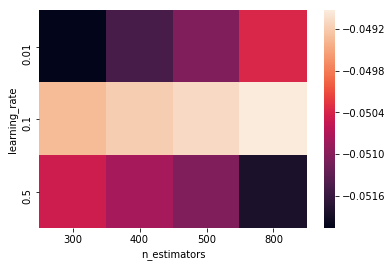

In [49]:
sb.heatmap(cvres.pivot('learning_rate', 'n_estimators', 'mean_test_score'))

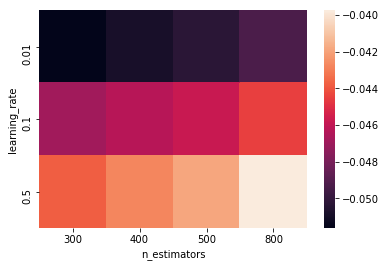

In [51]:
sb.heatmap(cvres.pivot('learning_rate', 'n_estimators', 'mean_train_score'))

## num_leaves tunning

In [65]:
params_std = {
    'objective': 'regression_l2',
    'boosting_type': 'gbdt',
    'bagging_fraction': 0.8,
    'feature_fraction': 0.8,
    'n_estimators': 800,
    'learning_rate': 0.1,
}

In [66]:
lgb_reg = lgb.LGBMRegressor(**params_std)

In [67]:
from sklearn.model_selection import GridSearchCV, KFold

In [68]:
params_grid = {
    'num_leaves': [11, 23, 31, 61, 91, 121],
}

In [69]:
grid = GridSearchCV(lgb_reg, params_grid, scoring='neg_mean_squared_error', cv=KFold(8, True), verbose=10, n_jobs=4)

In [70]:
grid.fit(train_features, y, categorical_feature=categorical_indices)

Fitting 8 folds for each of 6 candidates, totalling 48 fits


[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed: 22.3min
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed: 38.8min
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed: 74.5min
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed: 103.5min
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed: 195.6min
[Parallel(n_jobs=4)]: Done  46 out of  48 | elapsed: 341.1min remaining: 14.8min
[Parallel(n_jobs=4)]: Done  48 out of  48 | elapsed: 356.2min finished
C:\Data\Soft\Anaconda3\lib\site-packages\lightgbm\basic.py:1038: UserWarning: categorical_feature in Dataset is overridden. New categorical_feature is [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
  warnings.warn('categorical_feature in Dataset is overridden. New categorical_feature is {}'.format(sorted(list(categorical_feature))))


GridSearchCV(cv=KFold(n_splits=8, random_state=None, shuffle=True),
       error_score='raise',
       estimator=LGBMRegressor(bagging_fraction=0.8, boosting_type='gbdt', class_weight=None,
       colsample_bytree=1.0, feature_fraction=0.8, learning_rate=0.1,
       max_depth=-1, min_child_samples=20, min_child_weight=0.001,
       min_split_gain=0.0, n_estimators=800, n_jobs=-1, num_leaves=31,
       objective='regression_l2', random_state=None, reg_alpha=0.0,
       reg_lambda=0.0, silent=True, subsample=1.0,
       subsample_for_bin=200000, subsample_freq=1),
       fit_params=None, iid=True, n_jobs=4,
       param_grid={'num_leaves': [11, 23, 31, 61, 91, 121]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_mean_squared_error', verbose=10)

In [72]:
grid.best_score_

-0.04872088159401015

In [74]:
cvres2 = pd.DataFrame(grid.cv_results_['params'])
cvres2['mean_test_score'] = grid.cv_results_['mean_test_score']
cvres2['mean_train_score'] = grid.cv_results_['mean_train_score']

C:\Data\Soft\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:122: FutureWarning: You are accessing a training score ('mean_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)


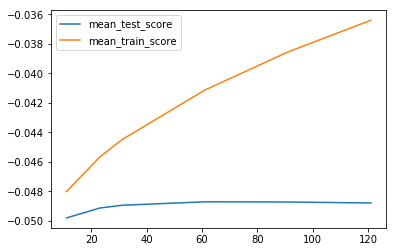

In [76]:
plt.plot(cvres2['num_leaves'], cvres2['mean_test_score'])
plt.plot(cvres2['num_leaves'], cvres2['mean_train_score'])
plt.legend()

In [77]:
create_submission(grid.predict(test_features), '../submissions/', 'lgbm_tuned_800_01_61', test_df)

C:\Data\Soft\Anaconda3\lib\site-packages\lightgbm\basic.py:447: UserWarning: Converting data to scipy sparse matrix.
  warnings.warn('Converting data to scipy sparse matrix.')
